In [66]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import cmath
from time import time
from scipy import interpolate
import  scipy.stats as  sc

class Hw3_FFT:
    def __init__(self, sigma, v0, kappa, p,q, theta, s0, r, k,T):
        self.sigma = sigma
        self.v0 = v0
        self.kappa = kappa
        self.p = p
        self.theta = theta
        self.s0 = s0
        self.r =r
        self.k = k
        self.T = T
        self.q = q
        
    def  Heston_Model_CF (self, u):
        '''charactristic function of density'''
        theta = self.theta
        kappa = self.kappa
        p = self.p
        sigma =self.sigma
        t = self.T
        s0 = self.s0
        r = self.r
        q = self.q
        i = complex(0,1)
        # lambda
        Lambda = np.sqrt(sigma**2 * (u**2 + i * u) + (kappa - i * p * sigma * u)**2)
        # w
        wu = np.exp(i * u * np.log(s0) + i * u * (r - q) * t  + \
            (kappa * theta * t * (kappa - i * p * sigma * u)) / sigma**2)

        wd = (cmath.cosh(Lambda * t / 2) + (kappa - i * p * sigma * u)/
                   Lambda * cmath.sinh(Lambda * t / 2))**(2 * kappa * theta / sigma**2)
        w = wu/wd
        # cf
        cf = w * np.exp( -(u**2 + i * u) * self.v0/
                (Lambda / cmath.tanh(Lambda * t / 2) + kappa - i * p * sigma * u))
        return cf
    
    def indicator (self,n):
        '''indicator factor'''
        y = np.zeros(len(n),dtype = complex)
        y[n==0] = 1
        return y
    
    def Heston_Model_FFT(self, alpha,n,B,K):
        '''calculate the price via FFT'''

                # set the parameter
        a = alpha
        theta = self.theta
        kappa = self.kappa
        p = self.p
        sigma =self.sigma
        t = self.T
        s0 = self.s0
        r = self.r
        N = 2**n
        dv = B / N
        dvdk = 2 * np.pi / N
        dk = dvdk / dv
        j = np.arange(1,N+1,dtype = complex)
        vj = (j - 1) * dv
        m = np.arange(1,N+1,dtype = complex)
        beta = np.log(s0) - dk * N / 2
        km = beta + (m-1) *dk
        i = complex(0,1)
        vj_ = []
        
        
#       set x and calculate y
        for count in range(0,N):
            u = vj[count] - (a + 1) * i
            cf = self.Heston_Model_CF(u)
            res =cf / ( 2 * (a +  vj[count] * i ) * (a + vj[count] * i + 1)) 
            vj_.append(res)
        vj_ = np.array(vj_)
        x = dv *vj_  * np.exp(- i * vj * beta) * (2 - self.indicator(j-1)) 
        y = np.fft.fft(x)
        
        
        # vector 
        yreal = np.exp(-alpha * np.array(km)) / np.pi * np.array(y).real
        
        # k_list
        k_List = list(beta + (np.cumsum(np.ones((N, 1))) - 1) * dk)
        kt = np.exp(np.array(k_List))
        k = []
        yreal_check = []
        #make sure the data is valid
        for i in range(len(kt)):
            if( kt[i]>1e-16 )&(kt[i] < 1e16)& ( kt[i] != float("inf"))&( kt[i] != float("-inf")) &( yreal[i] != float("inf"))&(yreal[i] != float("-inf")) & (yreal[i] is not  float("nan")):
                k.append(kt[i])
                yreal_check.append(yreal[i])
        tck = interpolate.splrep(k , np.real(yreal_check))
        price =  np.exp(-r * t)*interpolate.splev(K, tck).real

        return price

class mc_henson:
    def __init__(self,sigma,v0,kappa,p,theta,r,q,T,s0,k,k2):
        self.sigma = sigma
        self.v0 = v0
        self.kappa = kappa
        self.p = p
        self.r = r
        self.q = q
        self.T =T
        self.s0 = s0
        self.k = k
        self.k2 = k2
    def mcsimulation_Euler_discretization(self,trails):
        sigma,v0,kappa,p,r,q,T,s0,k,k2 = self.sigma,self.v0,self.kappa,self.p,self.r,self.q,self.T,self.s0,self.k,self.k2
        
        dt = T/period

        cov_matrix = dt*np.matrix([[1,p],[p,1]])

        s = np.zeros([trails,period])
        v = np.zeros([trails,period])

        s[:,0] = s0
        v[:,0] = v0
        for i in range(1,period):
    #         random = np.random.multivariate_normal(mean=[0,0],cov=cov_matrix,size=trails)
    #         s[:,i] = s[:,i-1] + (r-q) * s[:, i-1] * dt + np.sqrt( np.maximum ( v[:,i-1] , 0)) * s[:,i-1] * random[: , 0]
    #         v[:,i] = np.maximum(v[:, i-1] + k * (theta - v[:,i-1]) * dt +   sigma * np.sqrt(v[:,i-1]  ) * random[:,1],0)
            z = np.random.multivariate_normal(mean=[0,0],cov=cov_matrix,size = trails)
            s[:,i] = s[:,i-1] + (r-q) * s[:,i-1] * dt + np.array(np.sqrt(np.maximum(v[:,i-1],0)))*(np.array(s[:,i-1])) * z[:,0]
            v[:,i] = v[:,i-1] + kappa * (theta - v[:,i-1]) * dt + sigma * np.sqrt(np.maximum(v[:,i-1],0))*z[:,1]

        payoff = np.exp(-r*T)*sum(np.maximum(s[:,period-1] - k,0))/trails
        return s , payoff
    
    def u_o (self,N):
        
        path,nan = self.mcsimulation_Euler_discretization(N)
        payoff = np.maximum(path[:,-1]-k,0)
        payoff[path.max(axis=1)>k2] = 0
        price = np.exp(-r*T)*np.mean(payoff)
        return price
    def control(self,N,price):
        k,k2 = self.k, self.k2        
        c = self.optimal()[0]
        path = self.mcsimulation_Euler_discretization(N)[0]
        payoff = np.maximum(path[:,-1]-k,0)
        payoff[path.max(axis=1)>k2] = 0
        out_put = np.exp(-r*T)*np.mean(payoff)

        euro = np.mean(np.maximum(path[:,-1] - k,0))
        out_put_hat = out_put + (euro - price)*c
        return np.mean(out_put_hat)

    def optimal(self):
        sigma,v0,kappa,p,r,q,T,s0,k,k2 = self.sigma,self.v0,self.kappa,self.p,self.r,self.q,self.T,self.s0,self.k,self.k2
        N = 500
        out_put = np.zeros(N)
        euro = np.zeros(N)
        for i in range(N):
            df = self.mcsimulation_Euler_discretization(500)[0]
            euro[i] = np.mean(np.maximum(df[:,-1] - k,0))
            payoff = np.maximum(df[:,-1]-k,0)
            payoff[df.max(axis=1)>k2] = 0
            out_put[i] = np.exp(-r*T)*np.mean(payoff)
        c = -np.cov(out_put,euro)[0][1]/np.var(euro)
        return c , np.cov(out_put, euro)

In [14]:
r = 0.015
q = 0.0177
s0 = 282
T = 1
k = 285
n = 15
B = 1000
kappa, theta, sigma, p, v0 = (3.51,0.052,1.17,-0.77,0.034) 
alpha = 1

### 1
I use the parameter from homework 3 since it was tested by the professor with least squred error and stable outcomes.<br/>
Those, my parameter will be $3.51,0.052,1.17,-0.77,0.034$

### 2
I use business daily steps with $\frac{1}{252}$ and simulation with $40000$ times

## 3

### FFT

In [15]:
fft = Hw3_FFT(sigma, v0,kappa, p,q, theta, s0, r, k,T)

In [16]:
price_fft = fft.Heston_Model_FFT(alpha,n,B,k)

In [72]:
price_fft

17.528879915598804

### simulation

In [67]:
period = 252
N = 40000
k2 = 315
mc = mc_henson(sigma,v0,kappa,p,theta,r,q,T,s0,k,k2)
path, price_sim = mc.mcsimulation_Euler_discretization(N)
print(price_sim)
print('difference' , price_fft - price_sim)

17.60648564346626
difference -0.07760572786745712


the difference is $0.005$ <br/>
Small enough to be ignored


## 4 up and out

In [21]:
true  = mc.u_o(N);true

2.865287817303246

##### Use $N = 100000 $ as true price,which is 2.8888, i try different n and compare with true price to see the converge rate

[0.1196 0.046  0.0461 0.0317 0.0087]


,error
1000,0.119577
2500,0.046010
5000,0.046088
10000,0.031688
20000,0.008675


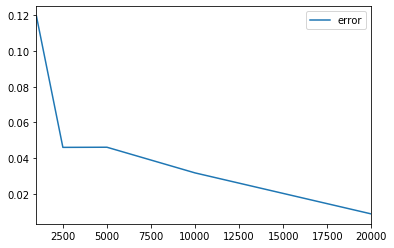

In [49]:
N =  [1000,2500,5000,10000,20000]
converge = [abs(mc.u_o(n) - true)/true for n in N]
print(np.array(converge).round(4))
converge = pd.DataFrame({'error': converge}, index=N)

converge.plot();converge

### 5

In [74]:
N =  [1000,2500,5000,10000,20000]
conv = [mc.control(n,price) for n in N]

,converge
1000,-0.018825
2500,0.038030
5000,0.034828
10000,0.030581
20000,0.000269


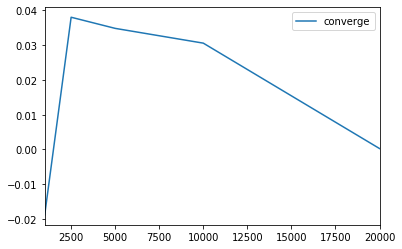

In [78]:

temp = (conv - true)/true 
converge = pd.DataFrame({'converge': temp}, index = N)
converge.plot();converge

In [68]:
mc.optimal()

(-0.001448748918327704, array([[0.08554849, 0.00138316],
        [0.00138316, 0.95664328]]))